# Infer SwinUNETR

In [1]:
!nvidia-smi

Wed Jul 20 11:56:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CardiacSeg

!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install monailabel-weekly
!pip install monai
!pip uninstall opencv-contrib-python -y
!pip install opencv-python==4.1.2.30 opencv-contrib-python==4.1.2.30

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CardiacSeg


In [3]:
import os
from pathlib import PurePath
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from monai.utils import first
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AddChannel,
    SaveImage,
    AsDiscrete,
    AsDiscreted,
    ToNumpyd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    LabelFilterd,
    MapLabelValued,
    SaveImaged,
    ToDeviced,
    EnsureTyped,
    SqueezeDimd
)


from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    NibabelWriter,
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    TestTimeAugmentation
)

from monai.transforms.utils import allow_missing_keys_mode
from monailabel.transform.post import BoundingBoxd, Restored

import torch
from torch.utils.tensorboard import SummaryWriter

import pandas as pd

## Setup config

In [34]:
is_infer_SegTHOR_dataset = True

class Config:
  model_repo = 'SwinUNETR_SegTHOR'
  model_name = 'crop_foreground'
  use_pretrained_model = True
  root_dir = './'
  infer_dir = os.path.join(root_dir, model_repo, 'infers', model_name)
  model_dir = os.path.join(root_dir, model_repo, 'models', model_name)
  pretrained_model_pth = os.path.join(model_dir, 'dc_97_best_metric_model.pth')

class SegTHORConfig(Config):
  use_crop_foreground = True
  infer_dir = os.path.join(Config.infer_dir, 'SegTHOR/Patient_40')
  img_pth = os.path.join(Config.root_dir, 'dataset/SegTHOR/train/Patient_40/Patient_40.nii.gz')
  lbl_pth = os.path.join(Config.root_dir, 'dataset/SegTHOR/train/Patient_40/GT.nii.gz')
  infer_img_pth = os.path.join(infer_dir, 'infer_Patient_40.nii.gz')
  transform_img_pth = os.path.join(infer_dir, 'trans_Patient_40.nii.gz')
  transform_lbl_pth = os.path.join(infer_dir, 'trans_GT.nii.gz')

class CHGHConfig(Config):
  use_crop_foreground = False
  pid = 'Patient_08' # corcta, Patient_05, Patient_07, Patient_08
  infer_dir = os.path.join(Config.infer_dir, f'chgh/{pid}')
  img_pth = os.path.join(Config.root_dir, f'dataset/chgh/{pid}/{pid}.nii.gz')
  lbl_pth = None
  infer_img_pth = os.path.join(infer_dir, f'infer_{pid}.nii.gz')


if is_infer_SegTHOR_dataset:
  config = SegTHORConfig
else:
  config = CHGHConfig

os.makedirs(config.infer_dir, exist_ok=True)

data_dict = {
  'image': config.img_pth,
  'label': config.lbl_pth,
}

## Setup pre transforms and post transforms


In [35]:
if config.__name__ == 'SegTHORConfig':
    pre_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        LabelFilterd(keys=["label"], applied_labels=[2]),
        MapLabelValued(keys=["label"], orig_labels=[0,2], target_labels=[0,1]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=['image','label'], source_key='label',margin=40),
        AddChanneld(keys=["image", "label"]),
        ToTensord(keys=["image", "label"]),
    ])
else:
    pre_transforms = Compose([
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        AddChanneld(keys=["image"]),
        ToTensord(keys=["image"]),
    ])

post_transforms = Compose([
    Orientationd(keys=["pred"], axcodes="LPS"),
    ToNumpyd(keys="pred"),
    Restored(keys=["pred"], ref_image="image"),
    BoundingBoxd(keys="pred", result="result", bbox="bbox")
])

## Check data shape and visualize

img path: ./dataset/SegTHOR/train/Patient_40/Patient_40.nii.gz
original img shape: (512, 512, 203)
transformed img shape: torch.Size([1, 1, 170, 153, 130])


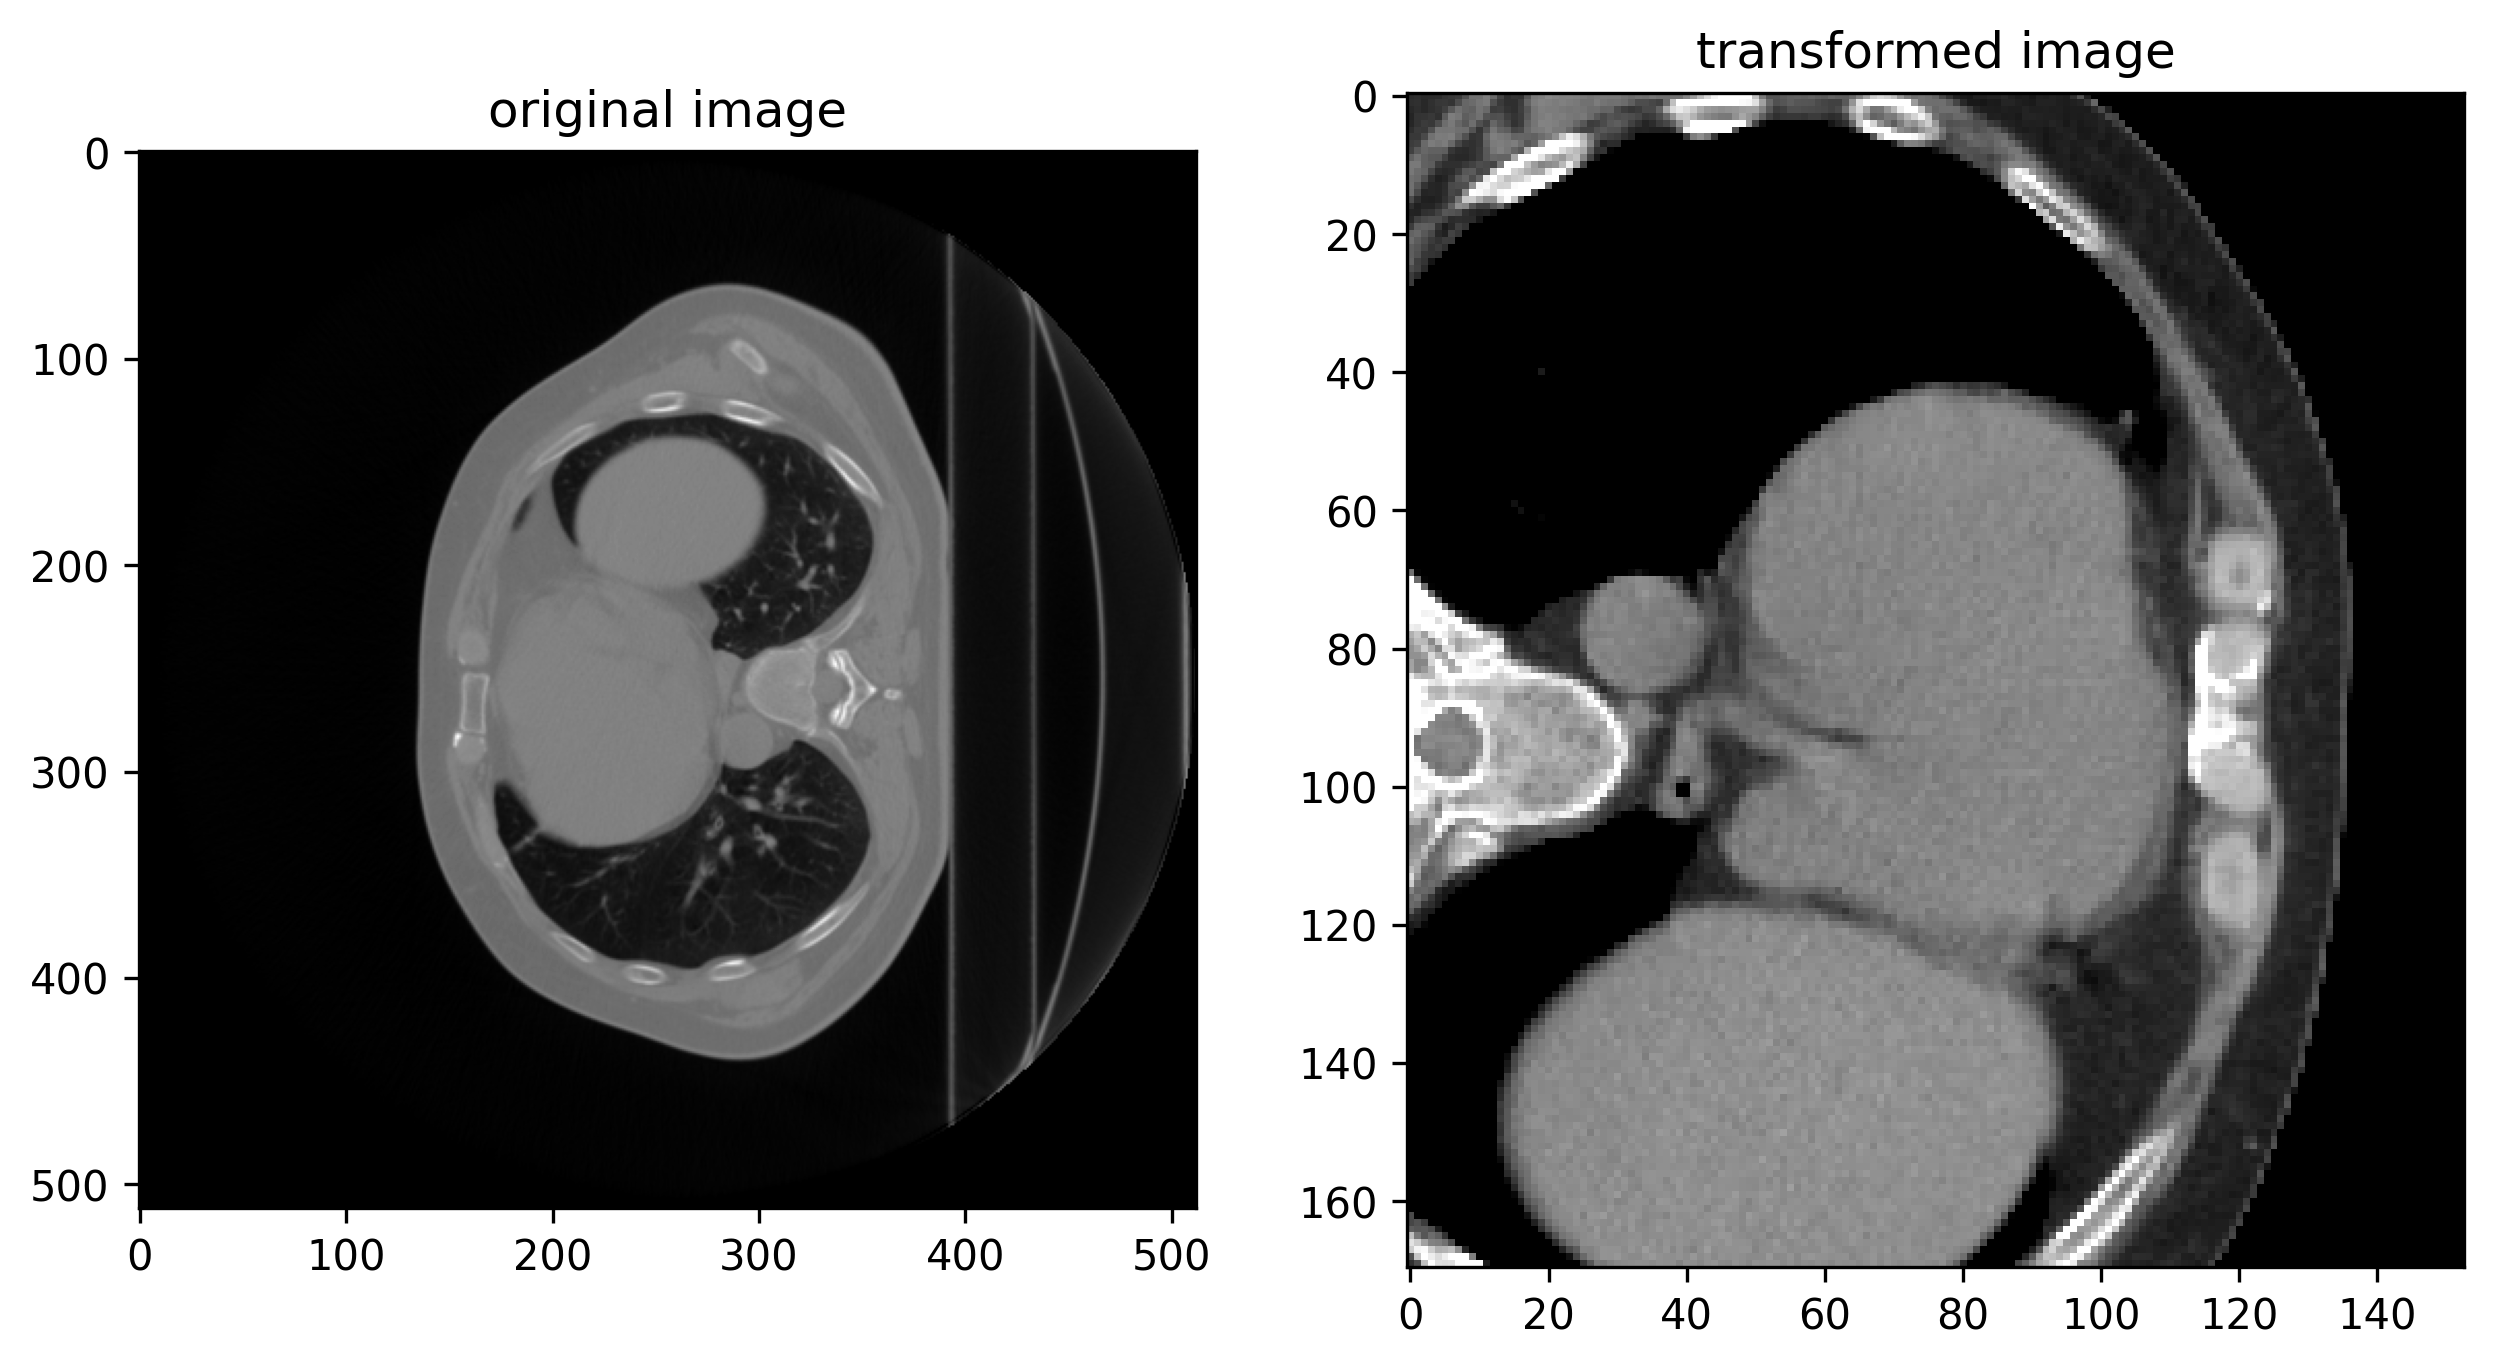

In [36]:
src_img = LoadImaged(keys=["image"])(data_dict)['image']
trfm_img = pre_transforms(data_dict)['image']
print(f"img path: {data_dict['image']}")
print(f"original img shape: {src_img.shape}")
print(f"transformed img shape: {trfm_img.shape}")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes[0].title.set_text("original image")
axes[0].imshow(src_img[:,:,80], cmap='gray')
axes[1].title.set_text("transformed image")
axes[1].imshow(trfm_img[0,0,:,:,60], cmap='gray')

## Create Swin UNETR model

In [37]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("cuda is available")
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    print("cuda is not available")
    device = torch.device("cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=2,
    feature_size=48,
    use_checkpoint=True,
).to(device)

cuda is available


In [38]:
use_pretrained_model = config.use_pretrained_model
pretrained_model_pth = config.pretrained_model_pth
if use_pretrained_model:
  model.load_state_dict(
      torch.load(
          pretrained_model_pth,
          map_location=device
      )
  )
  print(f'load pretrained model: {pretrained_model_pth}')
else:
  print(f'not load pretrained model')

load pretrained model: ./SwinUNETR_SegTHOR/models/crop_foreground/dc_97_best_metric_model.pth


## Infer

In [39]:
model.eval()
with torch.no_grad():
    data = pre_transforms(data_dict)
    data['pred'] = sliding_window_inference(
        data['image'].to(device), 
        (96, 96, 96),
        4, 
        model,
        overlap=0.8
    )
    data['pred'] = torch.argmax(data['pred'], dim=1)
    data = post_transforms(data)

None of the inputs have requires_grad=True. Gradients will be None


In [40]:
def show_img(img, pred, lbl=None):
    plt.rcParams["figure.dpi"] = 300
    plt.figure("check", (20, 10))

    if lbl is not None:
        plt.subplot(1, 4, 1)
        plt.title("image")
        plt.imshow(img, cmap="gray")

        plt.subplot(1, 4, 2)
        plt.title("image & label")
        plt.imshow(img, cmap="gray")
        lbl_masked = np.ma.masked_where(lbl == 0, lbl)
        plt.imshow(lbl_masked, 'viridis_r', interpolation='none', alpha=0.5)

        plt.subplot(1, 4, 3)
        plt.title("image & predict")
        plt.imshow(img, cmap="gray")
        pred_masked = np.ma.masked_where(pred == 0, pred)
        plt.imshow(pred_masked, 'Greens_r', interpolation='none', alpha=0.5)

        plt.subplot(1, 4, 4)
        plt.title("image & label & predict")
        plt.imshow(img, cmap="gray")
        plt.imshow(lbl_masked, 'viridis_r', interpolation='none', alpha=0.5)
        plt.imshow(pred_masked, 'Greens_r', interpolation='none', alpha=0.5)

        plt.show()

    else:
        plt.subplot(1, 2, 1)
        plt.title("image")
        plt.imshow(img, cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title("image & predict")
        plt.imshow(img, cmap="gray")
        pred_masked = np.ma.masked_where(pred == 0, pred)
        plt.imshow(pred_masked, 'Greens_r', interpolation='none', alpha=0.5)

        plt.show()

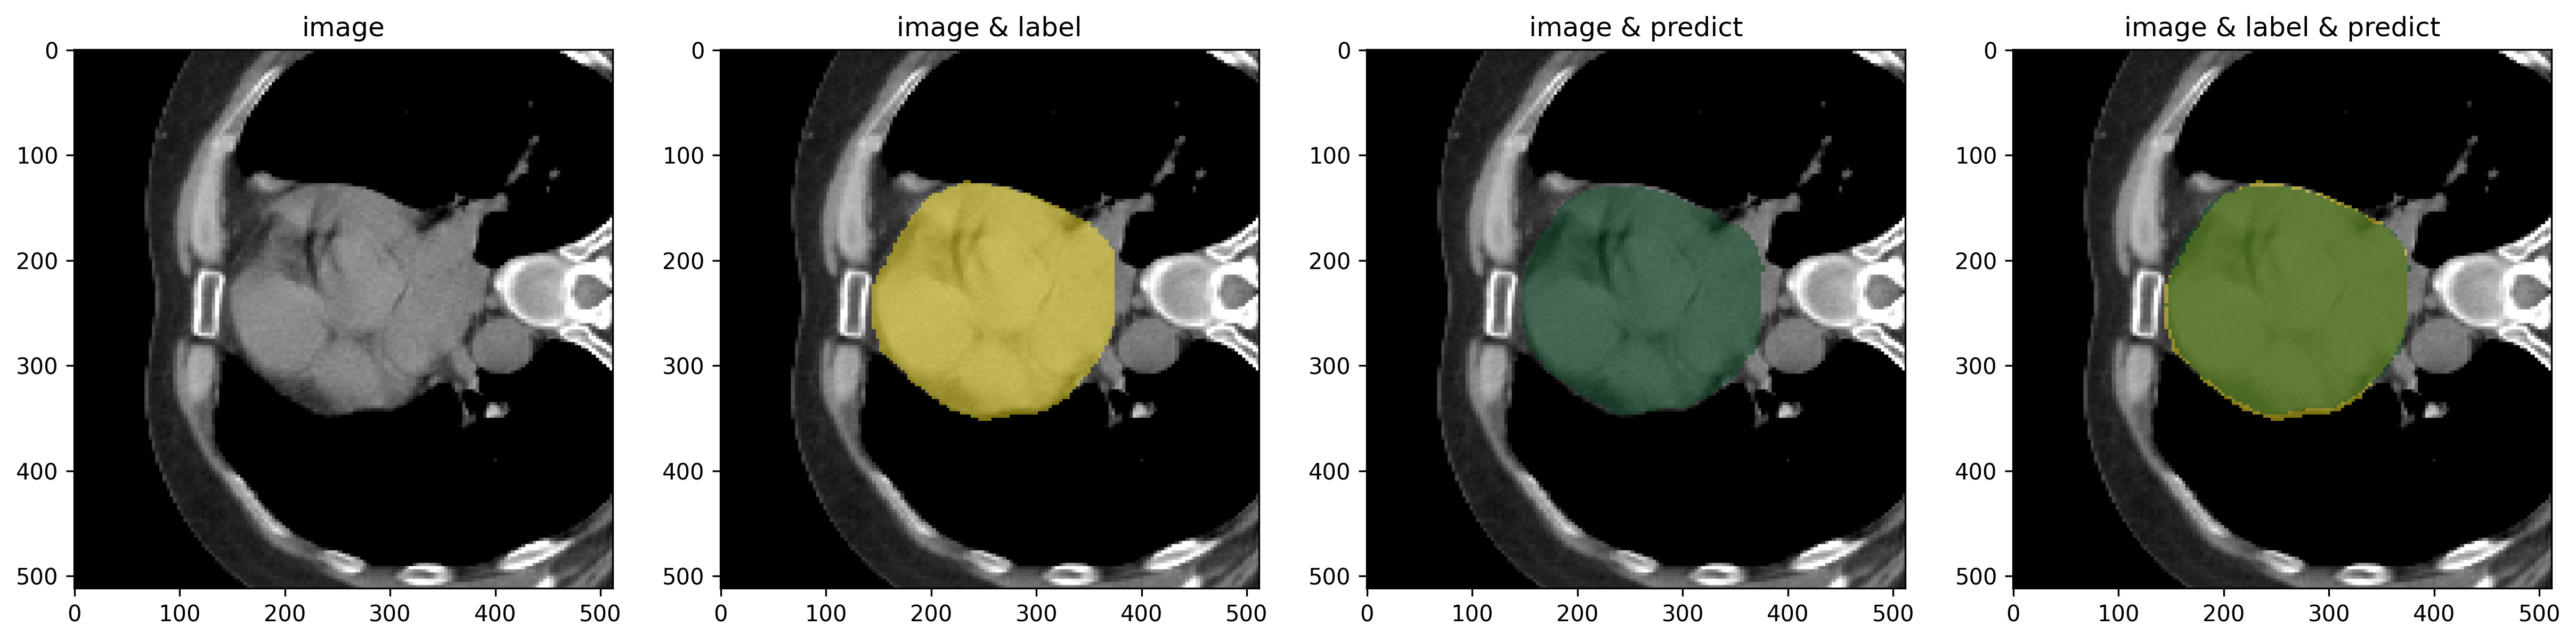

In [41]:
output_data = {}
if config.__name__ == 'SegTHORConfig':
    tmp_data = pre_transforms(data_dict)
    tmp_data['pred'] = data['image'][0]
    tmp_data = post_transforms(tmp_data)
    output_data['image'] = tmp_data['pred']
    output_data['image_meta_dict'] = tmp_data['pred_meta_dict']

    tmp_data2 = pre_transforms(data_dict)
    tmp_data2['pred'] = data['label'][0]
    tmp_data2 = post_transforms(tmp_data2)
    output_data['label'] = tmp_data2['pred']
    output_data['label_meta_dict'] = tmp_data2['pred_meta_dict']

    output_data['pred'] = data['pred']
    output_data['pred_meta_dict'] = data['pred_meta_dict']

    show_img(output_data['image'][:,:,120], output_data['pred'][:,:,120], output_data['label'][:,:,120])

else:
    img = LoadImaged(keys=["image"])(data_dict)['image']
    output_data['pred'] = data['pred']
    output_data['pred_meta_dict'] = data['pred_meta_dict']
    
    show_img(img[:,:,120], output_data['pred'][:,:,120])

In [42]:
def save_img(img, img_meta_dict, pth):
    writer = NibabelWriter()
    writer.set_data_array(AddChannel()(img))
    writer.set_metadata(img_meta_dict)
    writer.write(pth, verbose=True)

In [43]:
if config.__name__ == 'SegTHORConfig':
    save_img(output_data['image'], output_data['image_meta_dict'], config.transform_img_pth)
    save_img(output_data['label'], output_data['label_meta_dict'], config.transform_lbl_pth)
    save_img(output_data['pred'], output_data['pred_meta_dict'], config.infer_img_pth)
else:
    save_img(output_data['pred'], output_data['pred_meta_dict'], config.infer_img_pth)

2022-07-20 12:02:21,273 INFO image_writer.py:192 - writing: ./SwinUNETR_SegTHOR/infers/crop_foreground/SegTHOR/Patient_40/trans_Patient_40.nii.gz
2022-07-20 12:02:24,842 INFO image_writer.py:192 - writing: ./SwinUNETR_SegTHOR/infers/crop_foreground/SegTHOR/Patient_40/trans_GT.nii.gz
2022-07-20 12:02:27,192 INFO image_writer.py:192 - writing: ./SwinUNETR_SegTHOR/infers/crop_foreground/SegTHOR/Patient_40/infer_Patient_40.nii.gz
